In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
transform = transforms.ToTensor()

In [6]:
train_data = datasets.MNIST(root="../Data", train=True, download=True, transform=transform)

In [7]:
test_data = datasets.MNIST(root="../Data", train=False, download=True, transform=transform)

In [10]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X),dim=1)
        
        return X

In [12]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

In [13]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [16]:
import time
start_time = time.time()

# Variables(Trackes)
epochs = 5
train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

# Epochs
for epoch in range(epochs):
    train_corr = 0
    test_corr = 0

    # TRAIN
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch = batch+1
        if CUDA:
            X_train = X_train.cuda()
            y_train = y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        train_corr += (y_pred.argmax(axis=1) == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 600 == 0:
            print(f'Epoch [{epoch}/{epochs}]. Batch : {batch}. Loss : {loss.item()}')
        
    train_losses.append(loss)
    train_corrects.append(train_corr)
    
    # TEST
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            if CUDA:
                X_test = X_test.cuda()
                y_test = y_test.cuda()
            y_val = model(X_test)
            test_corr += (y_val.argmax(axis=1) == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corrects.append(test_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

Epoch [0/5]. Batch : 600. Loss : 0.20335471630096436
Epoch [0/5]. Batch : 1200. Loss : 0.6414305567741394
Epoch [0/5]. Batch : 1800. Loss : 0.01634938456118107
Epoch [0/5]. Batch : 2400. Loss : 0.02244677022099495
Epoch [0/5]. Batch : 3000. Loss : 0.00885276310145855
Epoch [0/5]. Batch : 3600. Loss : 0.009102092124521732
Epoch [0/5]. Batch : 4200. Loss : 0.0685952827334404
Epoch [0/5]. Batch : 4800. Loss : 0.004769043531268835
Epoch [0/5]. Batch : 5400. Loss : 0.0004062069929204881
Epoch [0/5]. Batch : 6000. Loss : 0.0031378469429910183
Epoch [1/5]. Batch : 600. Loss : 0.004590737167745829
Epoch [1/5]. Batch : 1200. Loss : 0.3490144610404968
Epoch [1/5]. Batch : 1800. Loss : 0.07315859198570251
Epoch [1/5]. Batch : 2400. Loss : 0.0006341033731587231
Epoch [1/5]. Batch : 3000. Loss : 0.0005574311944656074
Epoch [1/5]. Batch : 3600. Loss : 0.13341890275478363
Epoch [1/5]. Batch : 4200. Loss : 0.010514939203858376
Epoch [1/5]. Batch : 4800. Loss : 0.19620287418365479
Epoch [1/5]. Batch : 

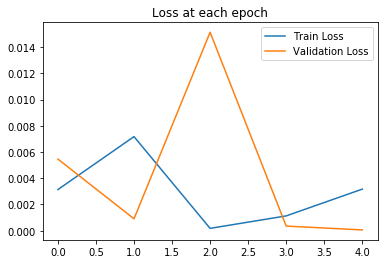

In [20]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at each epoch')
plt.legend()

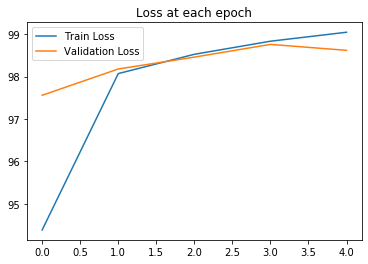

In [23]:
plt.plot([t.float()/600 for t in train_corrects], label='Train Loss')
plt.plot([t.float()/100 for t in test_corrects], label='Validation Loss')
plt.title('Loss at each epoch')
plt.legend()

In [24]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [27]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        if CUDA:
            X_test = X_test.cuda()
            y_test = y_test.cuda()
        y_pred = model(X_test)
        correct += (y_pred.argmax(1) == y_test).sum().float() / X_test.shape[0]
    print(correct)

tensor(0.9862, device='cuda:0')


In [33]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(y_pred.argmax(1).to('cpu'), y_test.view(-1).to('cpu')))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 978    0    2    0    0    2    6    3    8    1]
 [   0 1127    2    0    0    0    3    1    0    0]
 [   0    2 1018    0    0    0    0    6    1    0]
 [   0    2    2 1004    0   15    0    3    4    2]
 [   0    0    1    0  976    0    1    1    1    6]
 [   0    1    0    1    0  870    3    1    4    4]
 [   1    1    0    0    3    1  944    0    1    0]
 [   1    2    5    3    0    0    0 1006    0    3]
 [   0    0    2    1    0    0    1    2  950    4]
 [   0    0    0    1    3    4    0    5    5  989]]
